<a href="INSERT_colab_R_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#| label: exercise_2_a

# Exercise 2 (a)
Simulate a data set with $n = 100$ observations based on the relationship $y = \sin(x_1) + \varepsilon$ with noise term $\varepsilon$ following some distribution. Simulate $p=100$ additional covariates $x_2,\ldots,x_{101}$ that are not related to $y$.


#| label: install_packages

## Packages
If you want to reproduce the results, you'll need to install the following packages
```r
install.packages(c("glmnet", "dplyr", "keras", "caret"))
```
TODO Maybe remove caret

#| label: generating_data

## Generating the data

In [1]:
#| label: data_generation

set.seed(509)  # for reproducibility

num_points = 100
num_additional_covs = 100

# the reader may find it interesting to play around with the noise amount
noise_amount = 0.3

# create matrix of features
X = matrix(rnorm(num_points * (num_additional_covs + 1)), 
    nrow = num_points, ncol = num_additional_covs + 1)

y = sin(X[,1]) + rnorm(num_points, sd = noise_amount)

cat("X shape:", dim(X), "\n")
cat("y shape:", length(y))

X shape: 100 101 
y shape: 100

### Visualizing the relationships
Let's see the relationships of $y$ with $x_1$ and an unrelated covariate $x_2$

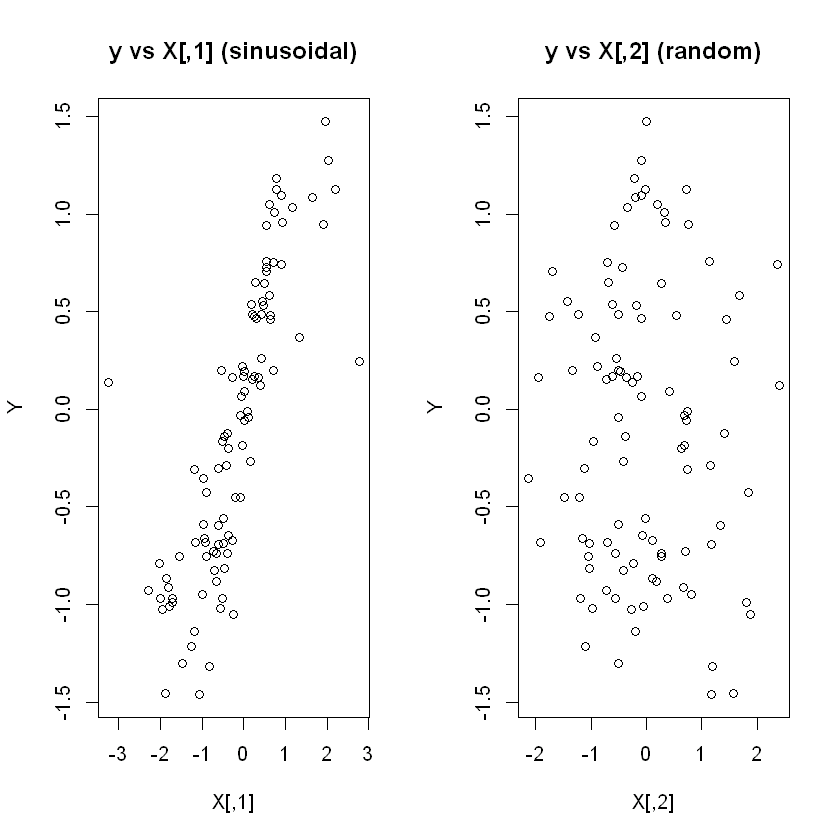

In [ ]:
#| label: visualizing_relationships
par(mfrow = c(1, 2))

# Plot 1: y vs X[,1] (sinusoidal relationship with small noise)
plot(X[,1], y, main = "y vs X[,1] (sinusoidal)", 
     xlab = "X[,1]", ylab = "y")

# Plot 2: y vs X[,2] (random)
plot(X[,2], y, main = "y vs X[,2] (random)", 
     xlab = "X[,2]", ylab = "y")

par(mfrow = c(1, 1))

#| label: exercise_2_b

# Exercise 2 (b)
On this data set, use different models (and software packages) of your choice to demonstrate

* overfitting and underfitting;
* L1, L2 and elastic net regularization;
* the underdetermined problem;
* the bias-variance trade-off;
* early stopping using a simple neural network.

#| label: under_over_fitting_intro

## Underfitting and Overfitting
Let's try to approximate the (sinusoidal) relationship between $y$ and $x_1$ with:

1) a simple linear model 
2) a polynomial model of degree 7. 

Also, in order for us to see the effects of under/over-fitting not only visually but also numerically, lets split the data into training and test sets and calculate the training and test errors for each model.

#| label: imports_and_splitting

### Imports and Splitting the Data


In [ ]:
#| label: imports_and_splitting
library(caret)
set.seed(509)

x_1 = X[, 1]

train_indices = createDataPartition(y, p = 0.8, list = FALSE)

X_train = x_1[train_indices]
X_test  = x_1[-train_indices]
y_train = y[train_indices]
y_test  = y[-train_indices]

train_df = data.frame(y = y_train, x = X_train)
test_df  = data.frame(x = X_test)

#| label: underfitting_demo

### Underfitting demonstration

#| label: lin_reg_fit_and_eval

#### Fitting Linear Regression and Evaluating the Model

In [5]:
#| label: lin_reg_fit_and_eval
lin_reg <- lm(y ~ x, data = train_df)

y_train_pred = predict(lin_reg)
y_test_pred = predict(lin_reg, newdata = test_df)

train_mse = mean((y_train - y_train_pred)^2)
test_mse = mean((y_test - y_test_pred)^2)

cat("Simple Linear Regression\n")
cat(sprintf("Train MSE: %.4f\n", train_mse))
cat(sprintf("Test  MSE: %.4f\n", test_mse))
cat(sprintf("Test error is higher by %.2f%%\n", ((test_mse - train_mse) / train_mse) * 100))

Simple Linear Regression
Train MSE: 0.1791
Test  MSE: 0.2415
Test error is higher by 34.79%


#| label: lin_reg_interpretation
#### Linear Regression Train/Test Error Interpretation

The error on the unseen data is significantly higher then the error on the training set which may indicate that the model is overfitting, but we must first ask ourselves whether or not the results on the training set are actually good. If the training error is significantly higher than the Bayes risk (i.e. the minimum possible error), then we may be underfitting the data.

Visual inspection will help us here as well:

#| label: lin_reg_visual_inspection

#### Linear Regression Visual Inspection

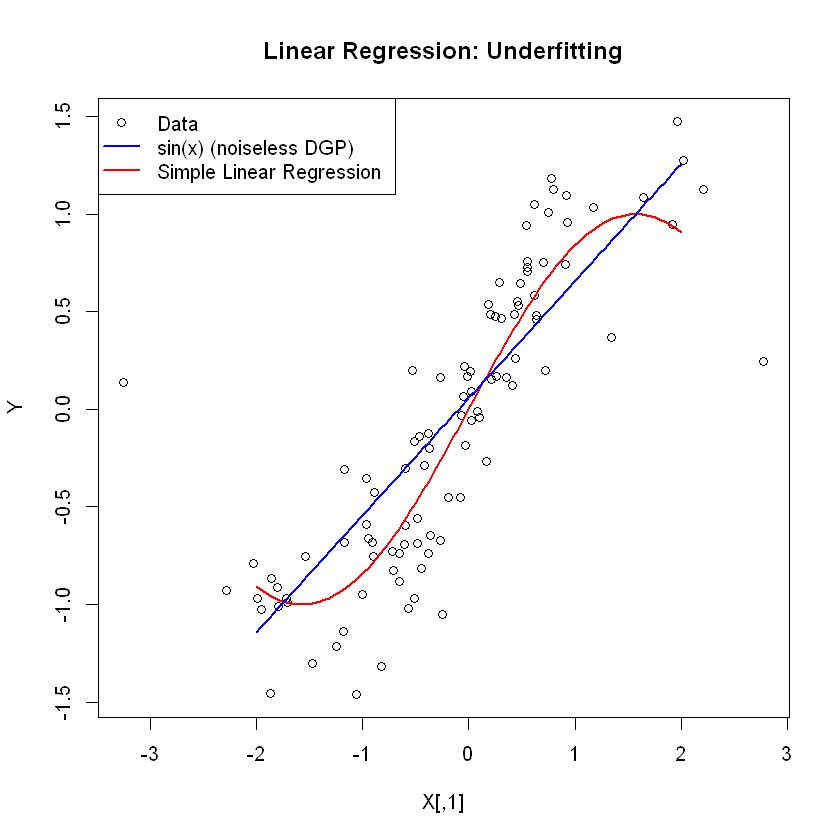

In [ ]:
#| label: lin_reg_visual_inspection
plot(x_1, y, main = "Linear Regression: Underfitting", xlab = "X[,1]", ylab = "y")

# noiseless DGP (Data Generating Process)
x_vals = seq(-2, 2, length.out = 100)
y_vals = sin(x_vals)
lines(x_vals, y_vals, col = "red", lwd = 2)

# simple linear regression prediction
y_pred = predict(lin_reg, newdata = data.frame(x = x_vals))
lines(x_vals, y_pred, col = "blue", lwd = 2)

legend("topleft", 
    legend = c("Data", "sin(x) (noiseless DGP)", "Simple Linear Regression"), 
    col = c("black", "blue", "red"), 
    lty = c(NA, 1, 1), 
    pch = c(1, NA, NA), 
    lwd = c(NA, 2, 2))

#| label: lin_reg_plot_interpretation

#### Linear Regression Plot Interpretation
By plotting the predictions against the actual data and the $\sin x$ function (noiseless DGP) we can see that the model lacks complexity $\Rightarrow$ suffers from underfitting problem.

#| label: overfitting_demo

### Overfitting demonstration

#| label: poly_reg_fit_and_eval

#### Fitting Polynomial Regression and Evaluating the Model

In [8]:
#| label: poly_reg_fit_and_eval
poly_degree = 50

# Creating our design matrix for the polynomial regression
X_train_poly = poly(X_train, degree = poly_degree, raw = TRUE)
X_test_poly = predict(X_train_poly, X_test)

# don't get confused by the model name, we are fitting it on the transformed data)
poly_reg = lm(y_train ~ X_train_poly)

y_train_pred = predict(poly_reg)
y_test_pred = predict(poly_reg, newdata = data.frame(X_train_poly = I(X_test_poly)))

train_mse = mean((y_train - y_train_pred)^2)
test_mse = mean((y_test - y_test_pred)^2)

cat("\nPolynomial Regression (degree=50)\n")
cat(sprintf("Train MSE: %.4f\n", train_mse))
cat(sprintf("Test  MSE: %.4f\n", test_mse))
cat(sprintf("Test error is higher by %.2f%%\n", ((test_mse - train_mse) / train_mse) * 100))

Warning message in predict.lm(poly_reg, newdata = data.frame(X_train_poly = I(X_test_poly))):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"



Polynomial Regression (degree=50)
Train MSE: 0.0685
Test  MSE: 1799797.4732
Test error is higher by 2626076709.95%


#| label: poly_reg_interpretation

#### Polynomial Regression Train/Test Error Interpretation

Test error is undescribably higher than the training error, this is a clear sign of overfitting. The model is too complex for the data and it has learned the noise in the training set.

Let's see this visually:

#| label: poly_reg_visual_inspection

#### Polynomial Regression Visual Inspection

Warning message in predict.lm(poly_reg, newdata = data.frame(X_train_poly = I(x_vals_poly))):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


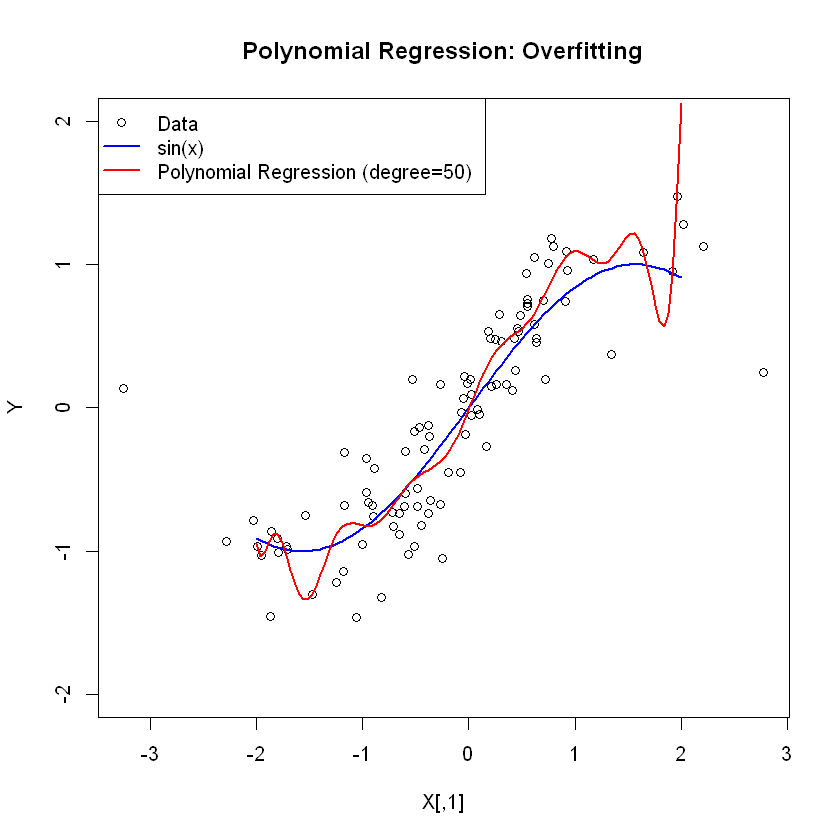

In [ ]:
#| label: poly_reg_visual_inspection
plot(x_1, y, main = "Polynomial Regression: Overfitting", xlab = "X[,1]", ylab = "y", ylim = c(-2, 2))

# noiseless DGP
x_vals = seq(-2, 2, length.out = 100)
y_vals = sin(x_vals)
lines(x_vals, y_vals, col = "blue", lwd = 2)

# polynomial regression prediction
x_vals_poly = poly(x_vals, degree = poly_degree, raw = TRUE)
y_pred = predict(poly_reg, newdata = data.frame(X_train_poly = I(x_vals_poly)))

lines(x_vals, y_pred, col = "red", lwd = 2)

legend("topleft", legend = c("Data", "sin(x)", 
    paste0("Polynomial Regression (degree=", poly_degree, ")")), 
    col = c("black", "blue", "red"), lty = c(NA, 1, 1), pch = c(1, NA, NA), lwd = c(NA, 2, 2))

#| label: poly_reg_plot_interpretation

#### Polynomial Regression Plot Interpretation
By looking at the predictions for the points around -1.3 we can nicely see how much the model bends to pass through the training data points, and learns the noise instead of the actual pattern.

The reader may find it interesting to decrease the degree of the polynomial to make the demonstration less extreme, and for degree = 7 you may even notice that the train/test errors alone indicate less overfitting than in the case of simple linear regression.

Also, we encourage the reader to try to find the optimal degree of the polynomial.

#| label: regularization_demo

## L1, L2 and Elastic Net Regularization

Now let's demonstrate different types of regularization techniques and observe how they affect the coefficient paths (for each hyperparameter lambda the resulting model's coefficients).

#| label: regularization_helper_function_R
### Helper Function for Plotting Regularization Paths

Here `glmnet`'s functionality is used. By setting the `alpha` parameter to 1, 0 or something in between we can get the Lasso, Ridge or Elastic Net regularization paths respectively.

#| label: l1_lasso_regularization

## L1 (Lasso) Regularization

For small lambda values (weak penalization) we can see that the uninformative covariates do have non-zero coefficients, but by increasing the lambda they eventually go to **exactly** zero. However, when we penalize the coefficients too strongly, the coefficient of $x_1$ also goes to zero, which is bad, since $x_1$ is actually informative.

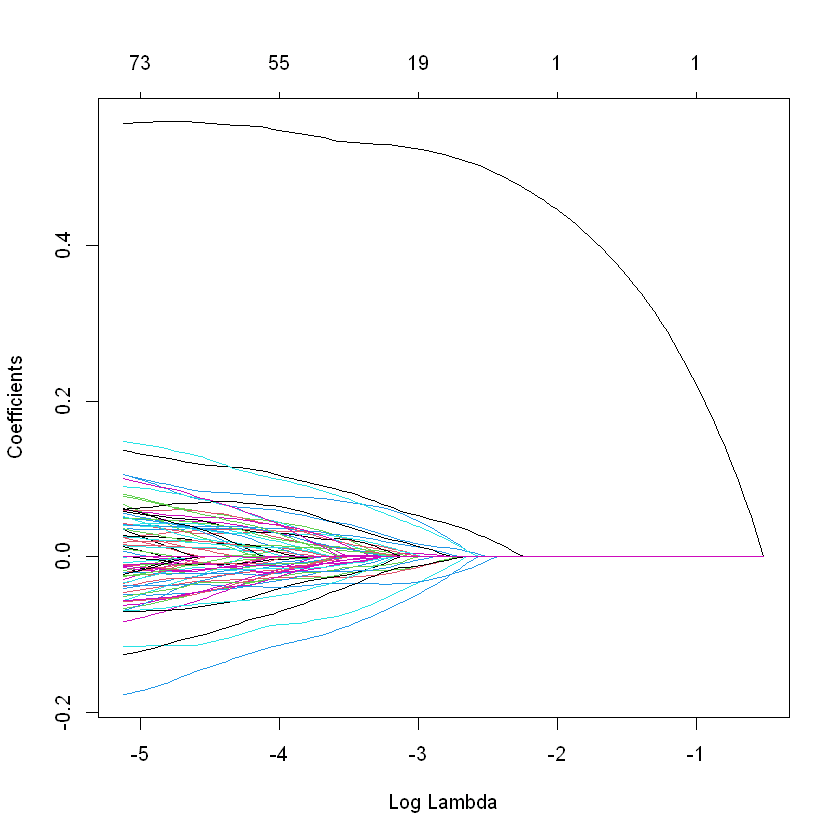

In [ ]:
#| label: l1_lasso_plot 
library(glmnet)
plot(glmnet(X, y, alpha=1), xvar = "lambda")

#| label: l2_ridge_regularization

## L2 (Ridge) Regularization

A few differences from the Lasso plot above:

- The lambda values are much bigger here (smallest being around $10^4$ instead of $10^{-3}$)
- As a result we also see that the coefficients are much smaller (0.0001 instead of 0.65)
- Also, most importantly the coefficients **do not go to zero**, but rather to very small values. The Lasso performs feature selection, while the Ridge does not. 

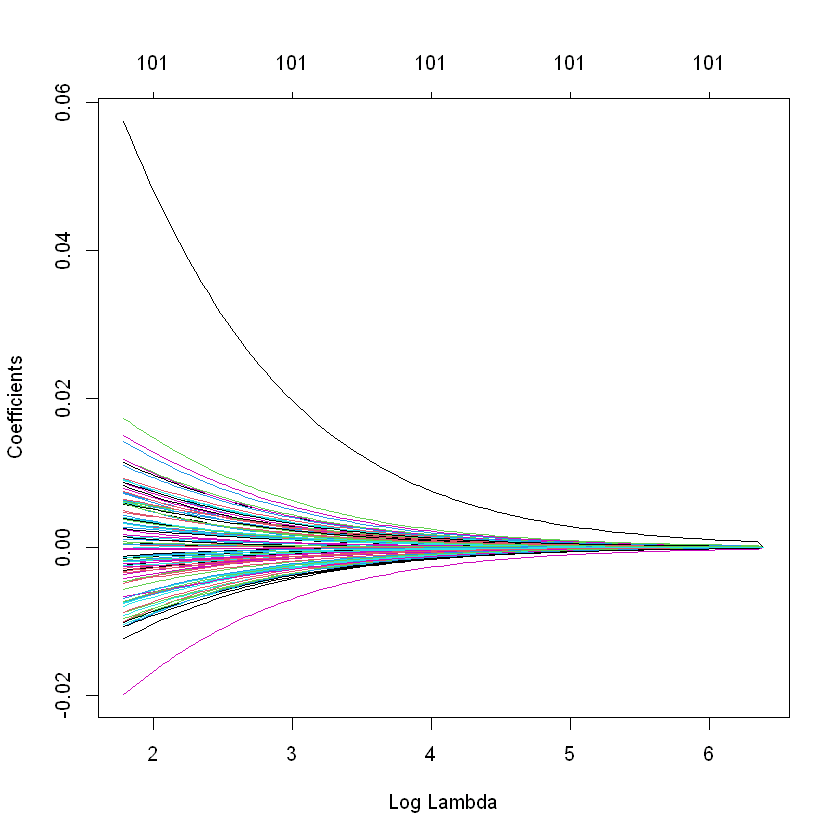

In [ ]:
#| label: l2_ridge_plot
plot(glmnet(X, y, alpha = 0), xvar = "lambda")

#| label: elastic_net_regularization

## Elastic Net Regularization (with alpha = 0.3)

This approach is somewhere in-between the two above - lambda values are bigger than Lasso, but not as big as Ridge.

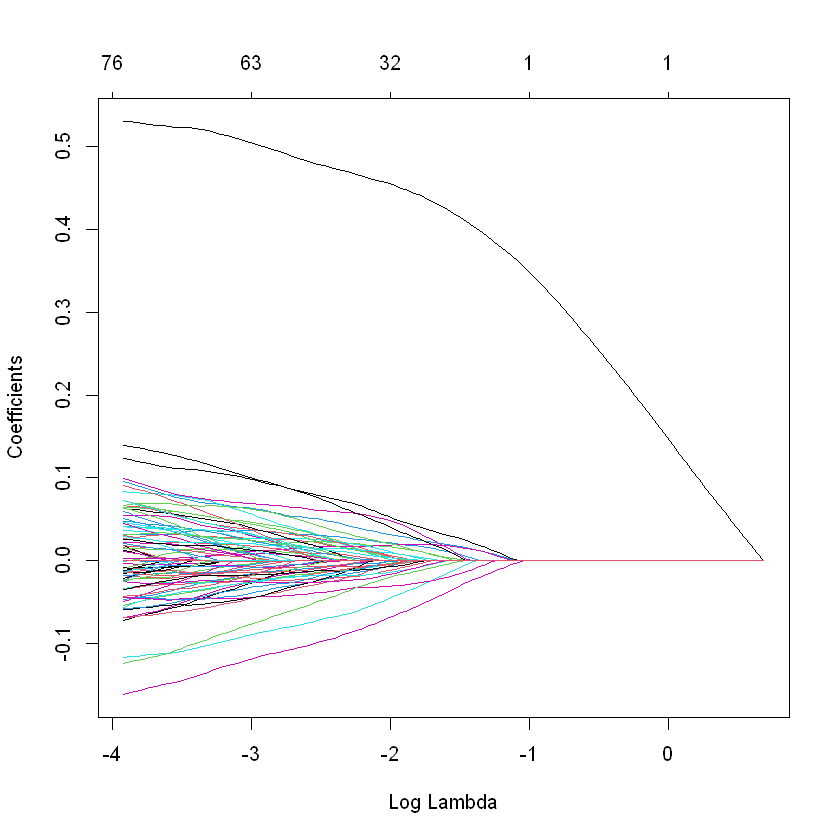

In [ ]:
#| label: elastic_net_plot
plot(glmnet(X, y, alpha = 0.3), xvar = "lambda")


#| label: regularization_comparison_note

### Comparing Regularization Methods

The reader may find it interesting to compare the plots for the same lambda values across different regularization techniques.

#| label: underdetermined_problem

## The Underdetermined Problem

As a reminder, we can obtain an analytic solution for a linear regression model with Mean Squared Error (MSE) loss by solving the normal equations 
$$
\beta = (X^TX)^{-1}X^TY
$$

The **underdetermined problem** arises when we have more covariates than observations, because in that case then the design matrix ($X$) is not full rank $\Rightarrow$ the inverse of the $X^T X$ does not exist $\Rightarrow$ we cannot solve the normal equations.

In [27]:
#| label: check_x_shape_determinant
cat("X shape:", dim(X), "\n")

# We have more covariates than samples, but practically this does not imply 
# that we have a zero determinant 
cat("Determinant of X^T X:", det(t(X) %*% X), "\n")

X shape: 100 101 
Determinant of X^T X: -3.181522e+144 


In [28]:
#| label: underdetermined_fewer_samples

# Let's select even fewer samples to demonstrate the underdetermined problem
X_head = X[1:10, ]
y_head = Y[1:10]

cat("Determinant of X_head^T X_head:", det(t(X_head) %*% X_head), "\n")

Determinant of X_head^T X_head: 0 


#| label: calc_xt_x_determinant

Although we see that the determinant is zero, let's try to compute the inverse (although in practice we would obtain the analytic solution (for the normal equation) by solving the System of Linear Equations $X^TX\beta = X^TY$, and avoiding the inverse altogether).

In [30]:
solve(t(X_head) %*% X_head)

ERROR: Error in solve.default(t(X_head) %*% X_head): system is computationally singular: reciprocal condition number = 2.59398e-20


#| label: inverse_existence_explanation

The code throws the error "Error in solve.default(t(X_head) %*% X_head): system is computationally singular: reciprocal condition number = 2.59398e-20" because the matrix is singular, meaning it does not have an inverse. 

The reader may find it interesting that the equivalent code in Python does produce an output (although it is mathematically impossible), since from the machine's perspective the matrix is not singular, because of the floating point approximations. The reader may dug deeper into the topic by following [this](https://stackoverflow.com/questions/28712734/numpy-possible-for-zero-determinant-matrix-to-be-inverted) Stack Overflow post. 

#| label: bias_variance_tradeoff

## The Bias-Variance Trade-off

Let's demonstrate the bias-variance trade-off by comparing polynomial models of different degrees.

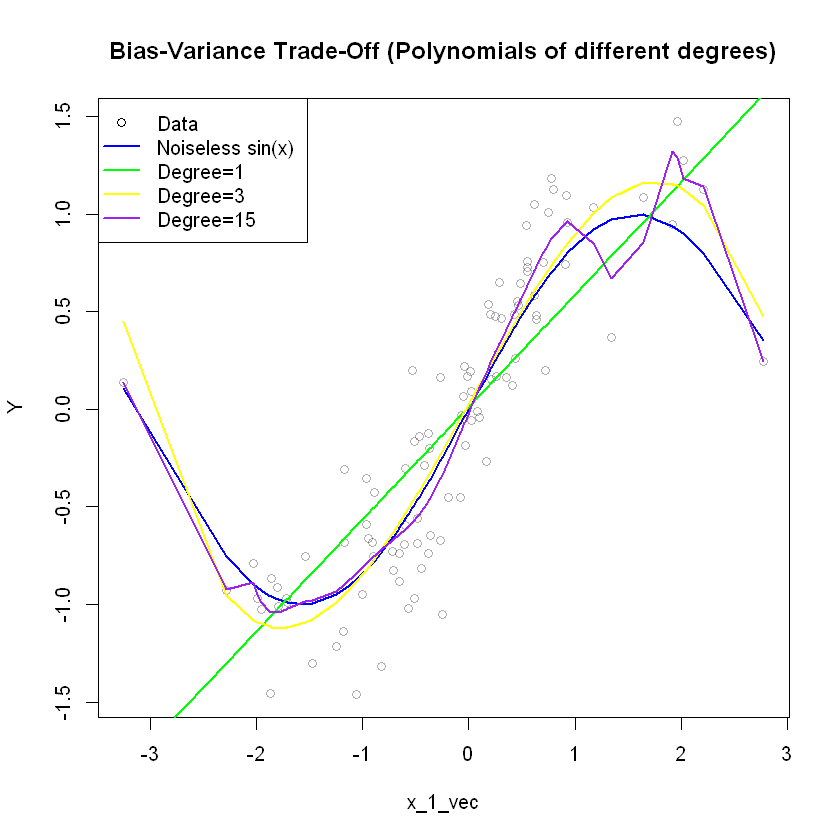

In [41]:
#| label: bias_variance_visualization

x_1_vec = X[, 1]
sorted_x_1 = sort(x_1_vec)

degrees = c(1, 3, 15)
colors = c("green", "yellow", "purple")

plot(x_1_vec, Y, col = rgb(0, 0, 0, 0.3), 
    main = "Bias-Variance Trade-Off (Polynomials of different degrees)")
lines(sorted_x_1, sin(sorted_x_1), col = "blue", lwd = 2)

for (i in 1:length(degrees)) {
    deg = degrees[i]
    col = colors[i]
    
    X_poly_tmp = poly(X[, 1], degree = deg, raw = TRUE)
    
    model_tmp = lm(Y ~ X_poly_tmp)
    sorted_x1_poly_tmp = predict(poly(X[, 1], degree = deg, raw = TRUE), sorted_x_1)
    
    Y_poly_tmp = predict(model_tmp, newdata = data.frame(X_poly_tmp = I(sorted_x1_poly_tmp)))
    lines(sorted_x_1, Y_poly_tmp, col = col, lwd = 2)
}

legend("topleft", legend = c("Data", "Noiseless sin(x)", paste0("Degree=", degrees)), 
       col = c("black", "blue", colors), lty = c(NA, 1, 1, 1, 1), 
       pch = c(1, NA, NA, NA, NA), lwd = c(NA, 2, 2, 2, 2))

#| label: bias_variance_interpretation

### Interpreting the Bias-Variance Trade-off

We can see that the green line (degree=1) is too simple and will have a underfitting (high bias) problem. On the other hand, the purple line (degree=15) is too complex and will have a overfitting (high variance) problem. The yellow line (degree=3) serves as a good compromise between the two.

We invite the reader to experiment with different degrees of the polynomial, maybe additionally looking at train/test errors and tring to find the optimal degree.

#| label: early_stopping_neural_network

## Early Stopping using a Simple Neural Network

First of all let's see how the model performs without early stopping.

In [3]:
TODO:
fix keras issues

ERROR: Error in parse(text = input): <text>:2:5: unexpected symbol
1: TODO:
2: fix keras
       ^


In [2]:
install.packages(c("reticulate", "tensorflow", "keras"))

library(reticulate)
reticulate::install_miniconda(force=TRUE)          # installs an isolated Miniconda

library(tensorflow)
tensorflow::install_tensorflow()         # installs TF into the "r-reticulate" env
# (keras::install_keras() also works; it wraps the same installer)


Warning message:
"package 'reticulate' is in use and will not be installed"
Installing packages into 'C:/Users/hayk_/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'tensorflow' successfully unpacked and MD5 sums checked
package 'keras' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\hayk_\AppData\Local\Temp\RtmpQdHJHA\downloaded_packages


* Installing Miniconda -- please wait a moment ...

* Downloading "https://repo.anaconda.com/miniconda/Miniconda3-latest-Windows-x86_64.exe" ...

+ "C:\Users\hayk_\AppData\Local\Temp\RtmpQdHJHA\Miniconda3-latest-Windows-x86_64.exe" /InstallationType=JustMe /AddToPath=0 /RegisterPython=0 /NoRegistry=1 /S /D=C:\Users\hayk_\AppData\Local\r-miniconda

+ "C:/Users/hayk_/AppData/Local/r-miniconda/condabin/conda.bat" update --yes --name base conda

+ "C:/Users/hayk_/AppData/Local/r-miniconda/condabin/conda.bat" create --yes --name r-reticulate "python=3.10" numpy --quiet -c conda-forge



ERROR: Error: Error creating conda environment 'r-reticulate' [exit code 1]


In [4]:
library(reticulate)
reticulate::use_condaenv("r-reticulate", required = TRUE)  # point to the env
reticulate::py_config()                                    # sanity check

library(keras)
library(tensorflow)


ERROR: Error in reticulate::use_condaenv("r-reticulate", required = TRUE): Unable to locate conda environment 'r-reticulate'.


In [2]:
library(dplyr)
library(keras)

neural_network <- keras_model_sequential()

neural_network %>% 
  layer_dense(units = 50, activation = "relu") %>%
  layer_dense(units = 50, activation = "relu") %>%
  layer_dense(units = 1, activation = "relu") %>%
  compile(
    optimizer = "adam",
    loss      = "mse",
    metric = "mse"
  )

history_minibatches <- fit(
  object           = neural_network, 
  x                = X, 
  y                = Y,
  batch_size       = 24, 
  epochs           = 100,
  validation_split = 0.2,
  callbacks = list(callback_early_stopping(patience = 50)),
  verbose = FALSE, # set this to TRUE to get console output
  view_metrics = FALSE # set this to TRUE to get a dynamic graphic output in RStudio
)
plot(history_minibatches)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'keras' was built under R version 4.4.3"


Warning message in normalizePath(path.expand(path), winslash, mustWork):
"path[1]="C:/Users/hayk_/AppData/Local/R/cache/R/reticulate/uv/cache/builds-v0/.tmpxtcRGa/Scripts": The system cannot find the path specified"


Error : could not find a Python environment for C:/


ERROR: Error: Installation of Python not found, Python bindings not loaded.
See the Python "Order of Discovery" here: https://rstudio.github.io/reticulate/articles/versions.html#order-of-discovery.


In [26]:
#| label: neural_network_early_stopping
# TensorFlow is used for simplicity, in practice we may often prefer torch
library(keras)
library(tensorflow)

set.seed(509)
tf$random$set_seed(509L)

# Ensure X and y are the right shapes
X_mat <- as.matrix(X)
y_vec <- as.numeric(y)

# Simple MLP model
neural_network <- keras_model_sequential() %>%
  layer_dense(units = 50, activation = "relu", input_shape = ncol(X_mat)) %>%
  layer_dense(units = 50, activation = "relu") %>%
  layer_dense(units = 1, activation = "linear")

neural_network %>% compile(
  optimizer = "adam",
  loss = "mse",
  metrics = list("mse")
)

history <- neural_network %>% fit(
  x = X_mat,
  y = y_vec,
  batch_size = 16,
  epochs = 100,
  validation_split = 0.2,
  verbose = 0
  # Uncomment below to actually use early stopping:
  # callbacks = list(
  #   callback_early_stopping(monitor = "val_loss",
  #                           patience = 10,
  #                           restore_best_weights = TRUE)
  # )
)

# Plot training vs validation loss
plot(history$metrics$loss,
     type = "l", lwd = 2,
     xlab = "Epochs", ylab = "Loss",
     main = "Early Stopping with Neural Network")
lines(history$metrics$val_loss, lwd = 2, lty = 2)
legend("topright",
       legend = c("Train Loss", "Validation Loss"),
       lty = c(1, 2), lwd = 2)


ERROR: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <Sequential name=sequential_25, built=False> (of type <class 'keras.src.models.sequential.Sequential'>)

In [25]:
#| label: neural_network_early_stopping

library(dplyr)
library(keras)

set.seed(509)

np <- import("numpy", convert = FALSE)  # keep Python objects as Python objects

# Simple MLP model
neural_network <- keras_model_sequential()
neural_network$add(layer_dense(units = 50, activation = "relu", input_shape = ncol(X)))
neural_network$add(layer_dense(units = 50, activation = "relu"))
neural_network$add(layer_dense(units = 1,  activation = "linear"))

neural_network$compile(optimizer = "adam", loss = "mse", metrics = list("mse"))

X_np <- np$array(X, dtype = "float64")
y_np <- np$array(y, dtype = "float64")

history <- neural_network$fit(
  x = X_np, 
  y = y_np,
  batch_size = 16, 
  epochs = 100,
  validation_split = 0.2, 
  verbose = 0 # Set to 1 if you want to see training logs
)

plot(history)

ERROR: Expected int32 passed to parameter 'size' of op 'Slice', got [80.0] of type 'list' instead. Error: Expected int32, but got 80.0 of type 'float'.

#| label: no_early_stopping_interpretation

### Interpreting Results Without Early Stopping

We can see that starting from epoch 15 model did not make any significant improvements. That's not the case here, but usually the model also starts to overfit to the training data, and the validation loss rises when we let it run for too many epochs. 

In order to avoid overfitting and use our computational resources more efficiently, we can use early stopping. We will track the validation loss and if for a given `patience` period (e. g. 5 epochs) the validation loss (`monitor`) does not improve by a given threshold (`min_delta`) (e. g. 0.01), we stop the training.

*Side note:*

In our case the validation loss did not start rising because the model had already achieved perfect fit (loss = 0) to the training data, so the weights were not updating anymore, and the validation loss did not change. Usually, for more complex DGP's achieving perfect fit is not possible.

c:\Users\hayk_\OneDrive\Desktop\03_lecture_sl\sl\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


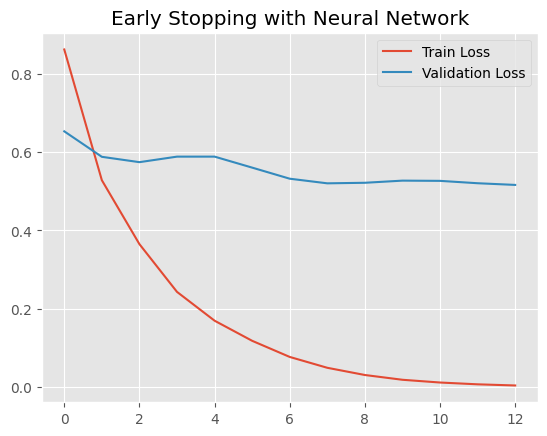

In [ ]:
#| label: early_stopping
library(dplyr)
library(keras)

set.seed(509)

# Create new model for early stopping demonstration
neural_network_early <- keras_model_sequential()

neural_network_early %>% 
  layer_dense(units = 50, activation = "relu", input_shape = c(ncol(X))) %>%
  layer_dense(units = 50, activation = "relu") %>%
  layer_dense(units = 1, activation = "linear") %>%
  compile(
    optimizer = "adam",
    loss      = "mse",
    metrics = c("mse")
  )

# Training with early stopping
history_early <- fit(
  object           = neural_network_early, 
  x                = X, 
  y                = Y,
  batch_size       = 16, 
  epochs           = 100,
  validation_split = 0.2,
  callbacks = list(callback_early_stopping(
    patience = 5,
    monitor = "val_loss",
    min_delta = 0.01,
    restore_best_weights = TRUE
  )),
  verbose = 0  
)

# Plot the training history
plot(history_early)

#| label: early_stopping_interpretation

### Interpreting Early Stopping Results

We see that the neural network ran only for approximately 12 epochs, although we specified 100 epochs. This is because we used early stopping and the optimizer stopped after 5 epochs without significant improvement in the validation loss.

We encourage the reader to split the data and look into train/test errors for the same neural network with and without early stopping. What do you observe regarding overfitting?